In [1]:
import math
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import SimpleITK as sitk
import torch.optim as optim
import torchvision
from copy import deepcopy

from UNet import UNet4, UNet3, UNet2

c:\Users\tonyz\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [36]:
!pip install pillow

In [2]:
DATASET_PATH = 'dataset'
TRAIN_X_PATH = os.path.join(DATASET_PATH, 'X_train_input')
VALID_X_PATH = os.path.join(DATASET_PATH, 'X_test_input')
TRAIN_Y_PATH = os.path.join(DATASET_PATH, 'X_train_target')
VALID_Y_PATH = os.path.join(DATASET_PATH, 'X_test_target')

In [3]:
def image_loader(mode, x_or_y, index):
    """
    Return the numpy image given the information.
    mode: 'train', 'valid' or 'test'
    x_or_y: 'x' or 'y', 'x' stands for the input and 'y' stands for the target
    index: int, the index of the image
    """
    if mode == 'train':
        if x_or_y == 'x':
            filepath = os.path.join(TRAIN_X_PATH, os.path.basename(TRAIN_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(TRAIN_Y_PATH, os.path.basename(TRAIN_Y_PATH)+'_'+str(index)+'.npy')
    elif mode == 'valid':
        if x_or_y == 'x':
            filepath = os.path.join(VALID_X_PATH, os.path.basename(VALID_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(VALID_Y_PATH, os.path.basename(VALID_Y_PATH)+'_'+str(index)+'.npy')
    else:
        raise ValueError("The first or the second parameter is not valid")
        
    if not isinstance(index, int):
        raise TypeError("Index should be an integer")
    
    if mode == 'train' and (index < 0 or index > 35339):
            raise IndexError("Image index out of range 0 - 35339")
            
    if mode == 'valid' and (index < 0 or index > 8834):
            raise IndexError("Image index out of range 0 - 8834")
    
    return np.load(filepath)

# Begin GIF creation section

ValueError: conversion not supported

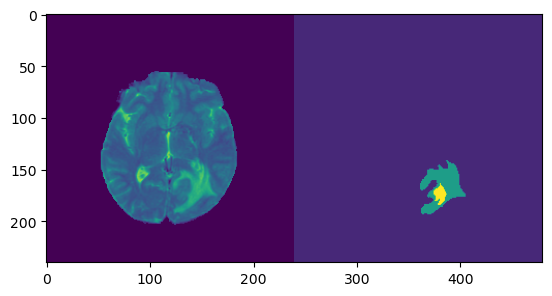

In [5]:
idx = 70
input_array = image_loader('valid', 'x', idx)
input_layer = input_array[:,:,3]
label_array = image_loader('valid', 'y', idx)

combined = np.hstack((input_layer*3, label_array))
plt.imshow(combined)
im = Image.fromarray((combined * (255/4)).astype('uint8'))
im.putpalette(Image.WEB)
im.show()

In [72]:
print(np.max(label_array))
print(np.min(label_array))

4
0


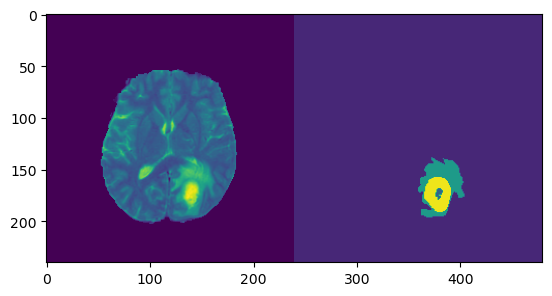

In [34]:
plt.imshow(combined)

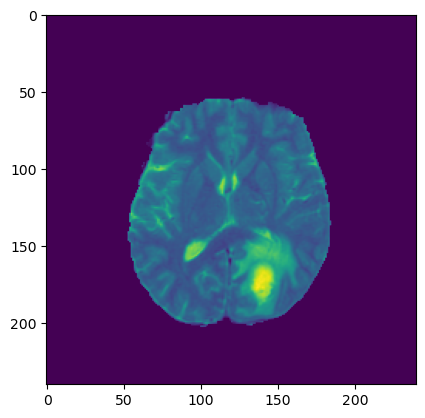

In [19]:
plt.imshow(input_layer)

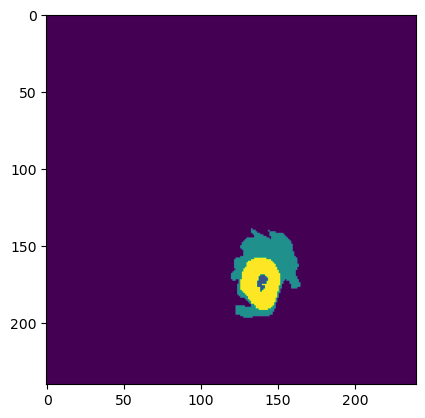

In [20]:
plt.imshow(label_array)

# Gif Creator:

load in model

In [4]:
def image_loader(mode, x_or_y, index):
    """
    Return the numpy image given the information.
    mode: 'train', 'valid' or 'test'
    x_or_y: 'x' or 'y', 'x' stands for the input and 'y' stands for the target
    index: int, the index of the image
    """
    if mode == 'train':
        if x_or_y == 'x':
            filepath = os.path.join(TRAIN_X_PATH, os.path.basename(TRAIN_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(TRAIN_Y_PATH, os.path.basename(TRAIN_Y_PATH)+'_'+str(index)+'.npy')
    elif mode == 'valid':
        if x_or_y == 'x':
            filepath = os.path.join(VALID_X_PATH, os.path.basename(VALID_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(VALID_Y_PATH, os.path.basename(VALID_Y_PATH)+'_'+str(index)+'.npy')
    else:
        raise ValueError("The first or the second parameter is not valid")
        
    if not isinstance(index, int):
        raise TypeError("Index should be an integer")
    
    if mode == 'train' and (index < 0 or index > 35339):
            raise IndexError("Image index out of range 0 - 35339")
            
    if mode == 'valid' and (index < 0 or index > 8834):
            raise IndexError("Image index out of range 0 - 8834")
    
    return np.load(filepath)

In [5]:
class Config():
    batch_size = 16
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = 6
    warmup = 0.1
    lr = 1e-5
    T_0 = 100  # period of the first restart, we do not want it to restart, so we set it a big number
    T_mult = 1  # period multiplier, it does not matter
    eta_min = lr/10  # minimum learning rate
    len_train_dataloader = None
    len_valid_dataloader = None

In [6]:
len_train = len(os.listdir(TRAIN_X_PATH))
Config.len_train_dataloader = len_train//Config.batch_size
len_train

len_valid = len(os.listdir(VALID_X_PATH))
Config.len_valid_dataloader = len_valid//Config.batch_size
len_valid

8835

In [7]:
# Pytorch version
# --------------------
# This version is fast and more reliable than SITK version
# Applies several random tansformations to an image and the label
# - Gaussian blur : image only
# - Rotation : image and label
# - Translation : image and label
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """
    try:
        # pytorch likes input to be in [C, H, W]
        input_layers = [input_array[i,:,:] for i in range(input_array.shape[0])]
        label_layers = [label_array]
        stacked_layers = np.array(input_layers + label_layers)
        stacked_tensor = torch.tensor(stacked_layers)

        # Gaussian blur
        blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1))
        # transformed = blurT.forward(input_tensor).numpy()

        # slight rotation
        rotationT = torchvision.transforms.RandomRotation(degrees = (-5,5))
        # transformed = rotationT.forward(input_tensor).numpy()

        # slight translation
        translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, 0.05))
        # transformed = translateT.forward(input_tensor).numpy()

        # apply transformations
        combinedT = torchvision.transforms.Compose([rotationT, translateT])
        transformed_stacked = combinedT(stacked_tensor)
        transformed_input = transformed_stacked[0:-1, :,:]
        transformed_input = blurT.forward(transformed_input).numpy() # add blur to input
        transformed_label = transformed_stacked[-1, :,:].numpy()

        # # turn back into original shape
        # transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])
    
    except:
        transformed_input = input_array
        transformed_label = label_array

    return transformed_input, transformed_label

In [8]:
# try prediction
class TrainDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_train

    def __getitem__(self, idx):
        x, y = image_loader('train', 'x', idx), image_loader('train', 'y', idx)
        x = x.transpose((2, 0, 1))
        x, y = transform(x, y)
        return x, y # NOTE the permute, => Batch*Channel*Wright*Height
    
class ValidDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_valid

    def __getitem__(self, idx):
        x, y = image_loader('valid', 'x', idx), image_loader('valid', 'y', idx)
        x = x.transpose((2, 0, 1))
        return x,y

train_dataset = TrainDataset()
valid_dataset = ValidDataset()
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)

In [24]:
# load in model, and try predictions
model = UNet3()
model = torch.load('UNet3, Epoch6, loss 0p0564.pt', map_location=torch.device('cpu'))

pred = []
target = []

for i, (inputs, targets) in enumerate(valid_dataloader):
    if i > 10:
        break
    outputs = model(inputs)
    result = torch.argmax(outputs.detach(), dim=1).numpy()
    
    # result = torch.argmax(outputs.detach(), dim=1)
    # pred_numpy=result.cpu().numpy().flatten().tolist()
    # target_numpy=targets.cpu().numpy().flatten().tolist()
    # total_pred.append(pred_numpy)
    # total_target.append(target_numpy)

    for i in range(result.shape[0]):
        pred.append(result[i,:,:])


In [19]:
print(pred[0].shape)

(16, 5, 240, 240)


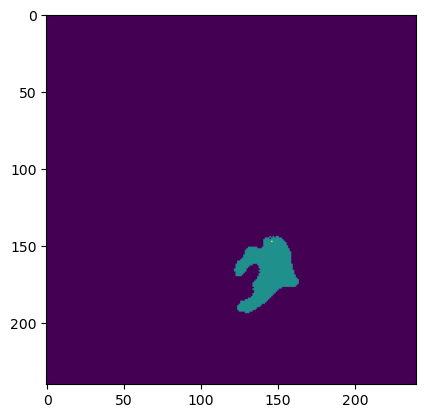

In [25]:
plt.imshow(pred[70])

In [27]:
from PIL import Image
# for idxs in range: 
#   grab the right layers
#   contatenate 
#   turn into PIL image
#   add to list
# turn list of images into gif


start_idx = 0
end_idx = 150

images = []

for idx in range(start_idx, end_idx):
    input_array = image_loader('valid', 'x', idx)
    input_layer1 = input_array[:,:,0] * 3 # make brighter
    input_layer2 = input_array[:,:,1] * 3 # make brighter
    input_layer3 = input_array[:,:,2] * 3 # make brighter
    input_layer4 = input_array[:,:,3] * 3 # make brighter
    label_array = image_loader('valid', 'y', idx)

    # change when model params arrive
    pred_label = pred[idx]

    # stack togther and make PIL image
    combined_top = np.hstack((input_layer1, input_layer2, label_array))
    combined_bottom = np.hstack((input_layer3, input_layer4, pred_label))
    combined = np.vstack((combined_top, combined_bottom))
    im = Image.fromarray((combined * (255/4)).astype('uint8'))

    images.append(im)

images[0].save('test.gif',
               save_all = True, append_images = images[1:], duration = 10, loop = 0)



# Begin Aug visualization

In [4]:
# Pytorch version
# --------------------
# This version is fast and more reliable than SITK version
# Applies several random tansformations to an image and the label
# - Gaussian blur : image only
# - Rotation : image and label
# - Translation : image and label
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """
    try:
        # pytorch likes input to be in [C, H, W]
        input_layers = [input_array[i,:,:] for i in range(input_array.shape[0])]
        label_layers = [label_array]
        stacked_layers = np.array(input_layers + label_layers)
        stacked_tensor = torch.tensor(stacked_layers)

        # corner is always clear of scan
        fill_val = float(input_array[0,0,0])

        # Gaussian blur
        # blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1))
        blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.02, 2)) # for dramatic effect
        # transformed = blurT.forward(input_tensor).numpy()

        # slight rotation
        # rotationT = torchvision.transforms.RandomRotation(degrees = (-5,5), fill = fill_val)
        rotationT = torchvision.transforms.RandomRotation(degrees = (-10,10), fill = fill_val)  # for dramatic effect
        # transformed = rotationT.forward(input_tensor).numpy()

        # slight translation
        # translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, 0.05), fill = fill_val)
        translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, 0.1), fill = fill_val) # for dramatic effect
        # transformed = translateT.forward(input_tensor).numpy()

        # apply transformations
        combinedT = torchvision.transforms.Compose([rotationT, translateT])
        transformed_stacked = combinedT(stacked_tensor)
        transformed_input = transformed_stacked[0:-1, :,:]
        transformed_input = blurT.forward(transformed_input).numpy() # add blur to input
        transformed_label = transformed_stacked[-1, :,:].numpy()
        

        # # turn back into original shape
        # transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])
    
    except ValueError:
        transformed_input = input_array
        transformed_label = label_array

    return transformed_input, transformed_label

In [52]:
# Pytorch version
# --------------------
# This version is fast and more reliable than SITK version
# Applies several random tansformations to an image and the label
# - Gaussian blur : image only
# - Rotation : image and label
# - Translation : image and label
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """
    try:
        # pytorch likes input to be in [C, H, W]
        input_layers = [input_array[i,:,:] for i in range(input_array.shape[0])]
        label_layers = [label_array]
        stacked_layers = np.array(input_layers + label_layers)
        stacked_tensor = torch.tensor(stacked_layers)

        # Gaussian blur
        blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1))
        # transformed = blurT.forward(input_tensor).numpy()

        # slight rotation
        rotationT = torchvision.transforms.RandomRotation(degrees = (-5,5))
        # transformed = rotationT.forward(input_tensor).numpy()

        # slight translation
        translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, 0.05))
        # transformed = translateT.forward(input_tensor).numpy()

        # apply transformations
        combinedT = torchvision.transforms.Compose([rotationT, translateT])
        transformed_stacked = combinedT(stacked_tensor)
        transformed_input = transformed_stacked[0:-1, :,:]
        transformed_input = blurT.forward(transformed_input).numpy() # add blur to input
        transformed_label = transformed_stacked[-1, :,:].numpy()

        # # turn back into original shape
        # transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])
    
    except:
        transformed_input = input_array
        transformed_label = label_array

    return transformed_input, transformed_label

In [53]:
idx = 1020
input_array = image_loader('valid', 'x', idx)
input_layer = input_array[:,:,3]
label_array = image_loader('valid', 'y', idx)

input_reorder = input_array.transpose((2, 0, 1))

x1, y1 = transform(input_reorder, label_array)
x2, y2 = transform(input_reorder, label_array)
x3, y3 = transform(input_reorder, label_array)

# turn back into original shape
x1_orig = np.array([[x1[:,i,j] for j in range(x1.shape[2])] for i in range(x1.shape[1])])
x2_orig = np.array([[x2[:,i,j] for j in range(x2.shape[2])] for i in range(x2.shape[1])])
x3_orig = np.array([[x3[:,i,j] for j in range(x3.shape[2])] for i in range(x3.shape[1])])


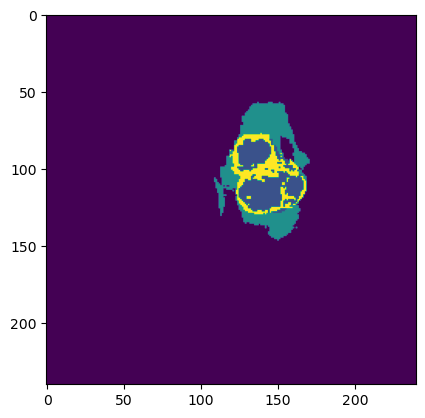

In [16]:
plt.imshow(label_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


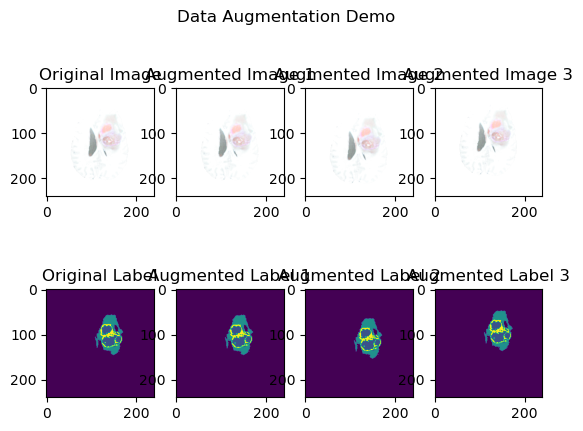

In [30]:
plt.subplot(2,4,1)
plt.imshow(input_array)
plt.title("Original Image")

plt.subplot(2,4,2)
plt.imshow(x1_orig)
plt.title("Augmented Image 1")

plt.subplot(2,4,3)
plt.imshow(x2_orig)
plt.title("Augmented Image 2")

plt.subplot(2,4,4)
plt.imshow(x3_orig)
plt.title("Augmented Image 3")

plt.subplot(2,4,5)
plt.imshow(label_array)
plt.title("Original Label")

plt.subplot(2,4,6)
plt.imshow(y1)
plt.title("Augmented Label 1")

plt.subplot(2,4,7)
plt.imshow(y2)
plt.title("Augmented Label 2")

plt.subplot(2,4,8)
plt.imshow(y3)
plt.title("Augmented Label 3")

plt.suptitle("Data Augmentation Demo")
plt.show()

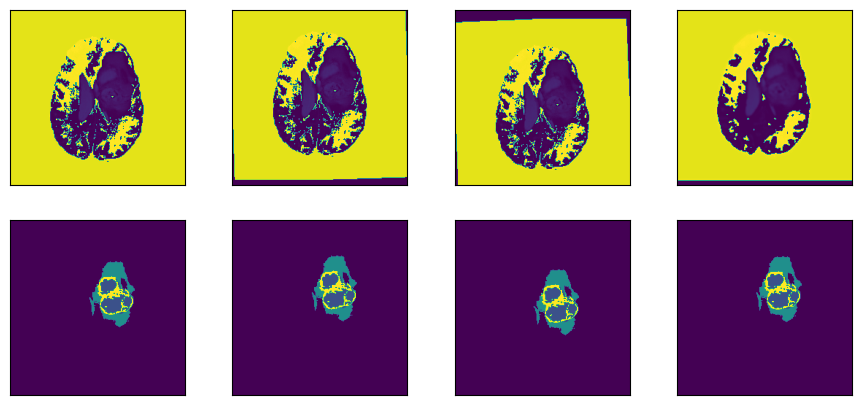

In [54]:
fig, axs = plt.subplots(2, 4, figsize=(11, 5))
imgs = [input_array[:,:,3], x1_orig[:,:,3], x2_orig[:,:,3], x3_orig[:,:,3], label_array, y1, y2, y3]
imgs = [(img * (255/4)).astype('uint8') for img in imgs]
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Augmented Image 1')

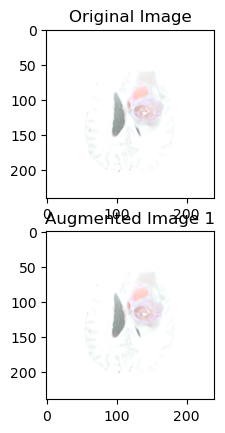

In [21]:
plt.subplot(2,1,1)
plt.imshow(input_array)
plt.title("Original Image")

plt.subplot(2,1,2)
plt.imshow(x1_orig)
plt.title("Augmented Image 1")